이 파일에선 다양한 스케일러로 데이터를 처리 했을 때, 결과의 차이가 어떻게 나타나나 비교해보려고 한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#필요한 lib으로 한번만 하고, jupyter환경에선 다신 실행 안하셔도되고, colab에선 실행할 때마다 해주심 됩니다.
!pip install catboost
!pip install lightgbm
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.7 MB/s eta 0:00:00


In [ ]:
# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime


# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn')
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV # 최상의 하이퍼 파라미터를 선정해주는 라이브러리
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix


import shap


pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings('ignore')


warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

<Figure size 1600x800 with 0 Axes>

In [ ]:
# 이제 마지막 데이터셋! 더이상 바뀔 일 없음
path = '/content/drive/MyDrive/Colab Notebooks/model/4.27_lendingclub_individual_dataset.csv'
df = pd.read_csv(path)
df

,emp_length_int,installment,int_rate,loan_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,mort_acc,num_rev_accts,open_acc,open_acc_6m,open_act_il,revol_bal,revol_util,loan_status,total_pymnt,funded_amnt_inv,earliest_cr_line_year,earliest_cr_line_month,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,verification_status_Source Verified,verification_status_Verified
0,2,822.95,14.47,35000.0,30.0,154.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,6.0,1.0,1.0,24640.0,0.354,Current,16430.860000,35000.0,2002,12,2018,9,5,717.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,10,680.82,24.99,23200.0,126.0,277.0,0.0,0.0,0.0,0.0,1.0,2.0,22.0,24.0,1.0,10.0,16909.0,0.559,Charged Off,8599.680000,23200.0,1993,5,2016,7,3,672.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,10,145.06,9.93,4500.0,127.0,265.0,0.0,0.0,0.0,1.0,1.0,0.0,27.0,22.0,2.0,0.0,6435.0,0.121,Current,4204.260000,4500.0,1995,11,2017,12,6,677.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,494.55,7.07,16000.0,134.0,400.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,18.0,1.0,2.0,3881.0,0.055,Charged Off,11804.280000,16000.0,1984,5,2017,10,7,822.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,5,146.10,10.42,4500.0,226.0,130.0,2.0,2.0,0.0,0.0,0.0,1.0,6.0,7.0,1.0,2.0,6824.0,0.494,Fully Paid,5134.174383,4500.0,1998,7,2017,5,6,702.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535624,7,133.78,19.99,3600.0,151.0,36.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,8.0,1.0,1.0,9711.0,0.908,Charged Off,469.070000,3600.0,2001,8,2014,3,3,667.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1535625,4,583.89,6.68,19000.0,125.0,216.0,0.0,0.0,0.0,0.0,0.0,5.0,16.0,15.0,1.0,4.0,11421.0,0.414,Fully Paid,20620.112719,18875.0,1997,3,2015,4,7,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1535626,9,329.65,14.33,9600.0,25.0,99.0,0.0,0.0,0

In [ ]:
# 계산을 위한 항은 미리 빼둠
df_cal = df[['loan_amnt','int_rate','total_pymnt','funded_amnt_inv']]
# 이중 total이랑 funded는 실제론 사용하면 안됨.

NameError: name 'df' is not defined

In [ ]:
df.drop(['total_pymnt','funded_amnt_inv'], axis = 1, inplace = True)

In [ ]:
# 결측치 있나 확인
df.isnull().sum()

In [ ]:
df.info()
# 이제부터 float형인 자료는 float 16으로 int 64는 int 8로 바꾼다. loan_status를 처리하고.

In [ ]:
not_deliq = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

loan_stat = df['loan_status']
target = []
for stat in loan_stat:
    # 연체 하지 않은 경우를 0
    if stat in not_deliq:
        target.append(0)
    # 연체한 경우를 1
    else:
        target.append(1)
print(len(target))
print(len(df))

1535629
1535629


In [ ]:
df['target'] = target

In [ ]:
# current와 issued를 제거
df = df[df['loan_status']!= 'Current']
df = df[df['loan_status']!= 'Issued']

In [ ]:
df.drop(columns = 'loan_status', inplace = True)

In [ ]:
x_data = list(df.columns)
x_data.remove('target')

In [ ]:
len(x_data)

95

In [ ]:
column_types = df.dtypes

# float와 int 나누기
float_columns = []
int_columns = []
for column_name, dtype in column_types.items():
    if dtype == 'float':
        float_columns.append(column_name)
    elif dtype == 'int':
        int_columns.append(column_name)

In [ ]:

# 데이터 유형에 따라 변환
df[float_columns] = df[float_columns].astype(np.float32)
df[int_columns] = df[int_columns].astype(np.int8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070411 entries, 1 to 1535627
Data columns (total 96 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   emp_length_int                       1070411 non-null  int8   
 1   installment                          1070411 non-null  float32
 2   int_rate                             1070411 non-null  float32
 3   loan_amnt                            1070411 non-null  float32
 4   mo_sin_old_il_acct                   1070411 non-null  float32
 5   mo_sin_old_rev_tl_op                 1070411 non-null  float32
 6   pub_rec                              1070411 non-null  float32
 7   pub_rec_bankruptcies                 1070411 non-null  float32
 8   chargeoff_within_12_mths             1070411 non-null  float32
 9   collections_12_mths_ex_med           1070411 non-null  float32
 10  inq_last_6mths                       1070411 non-null  float32
 11  mor

데이터셋의 크기가 확줄었다! 학습시간이 빨라진다.

In [ ]:
x_data

['emp_length_int',
 'installment',
 'int_rate',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'pub_rec',
 'pub_rec_bankruptcies',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'inq_last_6mths',
 'mort_acc',
 'num_rev_accts',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'revol_bal',
 'revol_util',
 'earliest_cr_line_year',
 'earliest_cr_line_month',
 'issue_d_year',
 'issue_d_month',
 'grade_numeric',
 'fico_range_mean',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'term_ 60 months',
 'addr_state_AL',
 'addr_state_AR',
 'addr_state_AZ',
 'addr_state_CA',
 'addr_state_CO',
 '

In [ ]:
processing = ['emp_length_int',
 'installment',
 'int_rate',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'pub_rec',
 'pub_rec_bankruptcies',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'inq_last_6mths',
 'mort_acc',
 'num_rev_accts',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'revol_bal',
 'revol_util']

# 이거만 바꿀지 다 바꿀지, 의견 물어보고 나의 의견도 제시하면 될듯.
# 우선은 dummy는 안바꾸는게 낫다는 의견 존재

### 1. Standard Scaler에 따른 결과
dummy, target을 제외한 부분을 scale 처리

In [ ]:
# standard로 scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[processing])

# 새로운 DF에 스케일된 데이터를 저장
df[processing] = scaled_data

In [ ]:
df

,emp_length_int,installment,int_rate,loan_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,mort_acc,num_rev_accts,open_acc,open_acc_6m,open_act_il,revol_bal,revol_util,earliest_cr_line_year,earliest_cr_line_month,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,verification_status_Source Verified,verification_status_Verified,target
1,1.143332,0.936948,2.476294,0.997169,0.017116,1.025329,-0.349729,-0.354519,-0.083211,-0.119392,0.406548,0.217902,0.960752,2.223063,0.094934,2.877302,0.028131,0.214564,-55,5,-32,7,3,672.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,-1.454716,0.228623,-1.265450,0.182952,0.171212,2.322994,-0.349729,-0.354519,-0.083211,-0.119392,-0.675987,0.735950,0.463837,1.145969,0.094934,-0.304219,-0.557886,-1.821005,-64,5,-31,10,7,822.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,-0.155692,-1.096422,-0.565961,-1.117535,1.943317,-0.525540,3.000930,5.011745,-0.083211,-0.119392,-0.675987,-0.300146,-1.026908,-0.828702,0.094934,-0.304219,-0.425506,-0.047960,-50,7,-31,5,6,702.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1.143332,0.801687,-0.655746,0.635295,0.460142,0.107468,-0.349729,-0.354519,-0.083211,-0.119392,-0.675987,-0.300146,1.457667,1.325485,0.094934,0.491161,0.015401,0.380156,-49,11,-33,9,6,677.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,-0.155692,0.181545,1.010499,0.522209,0.325308,0.276270,-0.349729,-0.354519,-0.083211,-0.119392,0.406548,0.735950,0.712295,-0.290156,1.060097,-1.099599,1.284369,0.194370,-46,3,-29,5,4,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535622,-0.935107,0.867093,0.864338,1.370352,2.058889,-0.377838,-0.349729,-0.354519,-0.083211,-0.119392,-0.675987,-0.300146,-0.281535,-0.469671,0.094934,-0.701909,0.383168,0.695184,-54,1,-35,2,5,697.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1535624,0.363918,-1.143271,1.432281,-1.219312,0.498666,-1.517252,-0.349729

In [ ]:
# 우선 랜덤하게 data_split하고 돌려봄 6:2:2
df_train, df_test = train_test_split(df, test_size = .2, train_size = .8, random_state = 42)

In [ ]:
# train셋을 oversampling
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train, y_train = smt.fit_resample(df_train[x_data], df_train['target'])

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1378292, 95)
(1378292,)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)


    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

In [ ]:
X_test = df_test[x_data]
y_test = df_test['target']

In [ ]:
prediction_times = []
training_times = []
scores = []

# gs를 해보고 얻은 결과.
xgboost = Train(XGBClassifier(max_depth= 10, min_child_weight= 6, learning_rate = 0.1, n_estimators= 100, penalty= 'ridge', objective = 'binary:logistic', eval_metric = 'auc'), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=150, max_depth=20, num_leaves=150,learning_rate = 0.1, objective = 'binary', verbose=False), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(l2_leaf_reg= 5, n_estimators=200, learning_rate = 0.1, verbose=False, depth=6, loss_function='Logloss'), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:07

Prediction time: 
Execution Time: 00:00:00
[LightGBM] [Info] Number of positive: 167182, number of negative: 689146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2439
[LightGBM] [Info] Number of data points in the train set: 856328, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195231 -> initscore=-1.416370
[LightGBM] [Info] Start training from score -1.416370
Training time: 
Execution Time: 00:00:06

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:08

Prediction time: 
Execution Time: 00:00:00


In [ ]:
models = [
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat)
]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgboost.predict(X_test)))
print(classification_report(y_test, lgb.predict(X_test)))
print(classification_report(y_test, cat.predict(X_test)))


              precision    recall  f1-score   support

           0       0.82      0.98      0.89    172469
           1       0.56      0.08      0.15     41614

    accuracy                           0.81    214083
   macro avg       0.69      0.53      0.52    214083
weighted avg       0.77      0.81      0.75    214083

              precision    recall  f1-score   support

           0       0.82      0.98      0.89    172469
           1       0.56      0.09      0.15     41614

    accuracy                           0.81    214083
   macro avg       0.69      0.54      0.52    214083
weighted avg       0.77      0.81      0.75    214083

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    172469
           1       0.58      0.07      0.12     41614

    accuracy                           0.81    214083
   macro avg       0.70      0.53      0.51    214083
weighted avg       0.77      0.81      0.74    214083



In [ ]:
model = [xgboost, lgb, cat]
threshold = np.linspace(20, 80,61)/100

In [ ]:
threshold

array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,
       0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41,
       0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52,
       0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63,
       0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74,
       0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ])

In [ ]:
# 테스트셋에 대한 예측 확률 가져오기
y_pred_proba = xgboost.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 예측 확률 가져오기
# 사용자가 정의한 임계값으로 예측을 바꾸기
confusion_matrices = {}

for cut in threshold:
    y_pred = (y_pred_proba >= cut).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[f"xgboost{cut}"] = cm

for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for xgboost0.2
[[114821  57648]
 [ 14133  27481]]

Confusion Matrix for xgboost0.21
[[119381  53088]
 [ 15346  26268]]

Confusion Matrix for xgboost0.22
[[123672  48797]
 [ 16539  25075]]

Confusion Matrix for xgboost0.23
[[127596  44873]
 [ 17752  23862]]

Confusion Matrix for xgboost0.24
[[131190  41279]
 [ 18935  22679]]

Confusion Matrix for xgboost0.25
[[134672  37797]
 [ 20054  21560]]

Confusion Matrix for xgboost0.26
[[137793  34676]
 [ 21101  20513]]

Confusion Matrix for xgboost0.27
[[140739  31730]
 [ 22183  19431]]

Confusion Matrix for xgboost0.28
[[143523  28946]
 [ 23265  18349]]

Confusion Matrix for xgboost0.29
[[146039  26430]
 [ 24294  17320]]

Confusion Matrix for xgboost0.3
[[148332  24137]
 [ 25232  16382]]

Confusion Matrix for xgboost0.31
[[150446  22023]
 [ 26179  15435]]

Confusion Matrix for xgboost0.32
[[152481  19988]
 [ 27109  14505]]

Confusion Matrix for xgboost0.33
[[154315  18154]
 [ 28001  13613]]

Confusion Matrix for xgboost0.34
[[1

In [ ]:
# 테스트셋에 대한 예측 확률 가져오기
y_pred_proba = lgb.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 예측 확률 가져오기
# 사용자가 정의한 임계값으로 예측을 바꾸기
confusion_matrices = {}

for cut in threshold:
    y_pred = (y_pred_proba >= cut).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[f"lgb{cut}"] = cm

for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

[LightGBM] [Warning] 1.2234781 is set=, 1.2234781= will be ignored. Current value: 1.2234781=
[LightGBM] [Warning] dtype: is set=, dtype:= will be ignored. Current value: dtype:=
[LightGBM] [Warning] [-0.9351066 is set=, [-0.9351066= will be ignored. Current value: [-0.9351066=
[LightGBM] [Warning] -0.6330278 is set=, -0.6330278= will be ignored. Current value: -0.6330278=
[LightGBM] [Warning] -0.6330278 is set=, -0.6330278= will be ignored. Current value: -0.6330278=
[LightGBM] [Warning] -0.6330278 is set=, -0.6330278= will be ignored. Current value: -0.6330278=
[LightGBM] [Warning] -0.6330278 is set=, -0.6330278= will be ignored. Current value: -0.6330278=
[LightGBM] [Warning] -0.6330278 is set=, -0.6330278= will be ignored. Current value: -0.6330278=
[LightGBM] [Warning] -0.6330278 is set=, -0.6330278= will be ignored. Current value: -0.6330278=
[LightGBM] [Warning] -0.6330278 is set=, -0.6330278= will be ignored. Current value: -0.6330278=
[LightGBM] [Warning] -0.6330278 is set=, -

In [ ]:
# 테스트셋에 대한 예측 확률 가져오기
y_pred_proba = cat.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 예측 확률 가져오기
# 사용자가 정의한 임계값으로 예측을 바꾸기
confusion_matrices = {}

for cut in threshold:
    y_pred = (y_pred_proba >= cut).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[f"cat{cut}"] = cm

for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for cat0.2
[[113888  58581]
 [ 13925  27689]]

Confusion Matrix for cat0.21
[[118761  53708]
 [ 15197  26417]]

Confusion Matrix for cat0.22
[[123344  49125]
 [ 16479  25135]]

Confusion Matrix for cat0.23
[[127484  44985]
 [ 17715  23899]]

Confusion Matrix for cat0.24
[[131317  41152]
 [ 18928  22686]]

Confusion Matrix for cat0.25
[[134959  37510]
 [ 20073  21541]]

Confusion Matrix for cat0.26
[[138271  34198]
 [ 21283  20331]]

Confusion Matrix for cat0.27
[[141332  31137]
 [ 22378  19236]]

Confusion Matrix for cat0.28
[[144161  28308]
 [ 23509  18105]]

Confusion Matrix for cat0.29
[[146813  25656]
 [ 24634  16980]]

Confusion Matrix for cat0.3
[[149196  23273]
 [ 25656  15958]]

Confusion Matrix for cat0.31
[[151378  21091]
 [ 26667  14947]]

Confusion Matrix for cat0.32
[[153355  19114]
 [ 27580  14034]]

Confusion Matrix for cat0.33
[[155234  17235]
 [ 28469  13145]]

Confusion Matrix for cat0.34
[[156984  15485]
 [ 29333  12281]]

Confusion Matrix for cat0.3

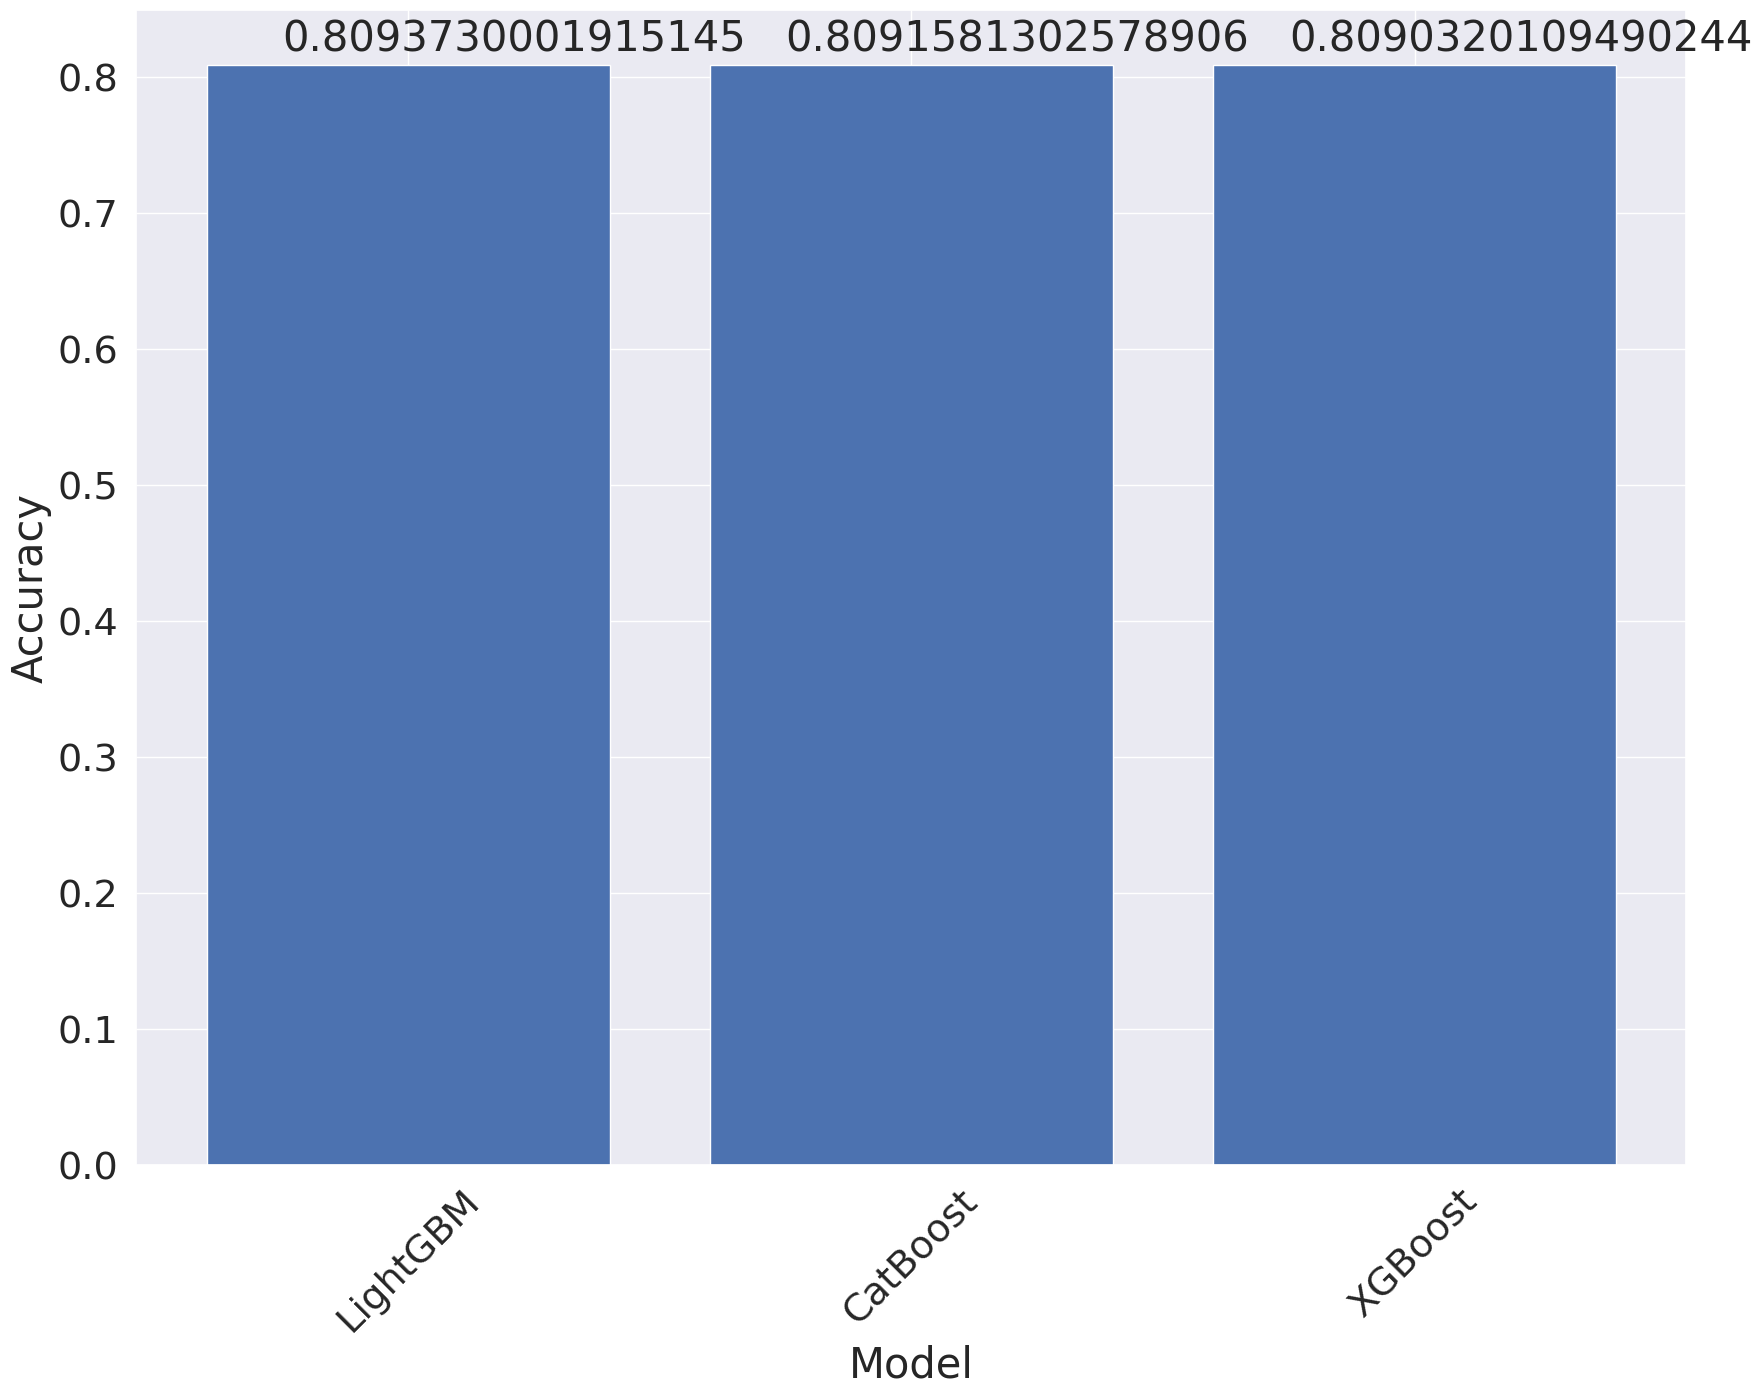

In [ ]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgboost.predict(X_test)))
print(classification_report(y_test, lgb.predict(X_test)))
print(classification_report(y_test, cat.predict(X_test)))


              precision    recall  f1-score   support

           0       0.82      0.98      0.89    172469
           1       0.56      0.08      0.15     41614

    accuracy                           0.81    214083
   macro avg       0.69      0.53      0.52    214083
weighted avg       0.77      0.81      0.75    214083

              precision    recall  f1-score   support

           0       0.82      0.98      0.89    172469
           1       0.56      0.09      0.15     41614

    accuracy                           0.81    214083
   macro avg       0.69      0.54      0.52    214083
weighted avg       0.77      0.81      0.75    214083

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    172469
           1       0.57      0.07      0.13     41614

    accuracy                           0.81    214083
   macro avg       0.69      0.53      0.51    214083
weighted avg       0.77      0.81      0.74    214083



## Confusion matrix

In [ ]:
confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(X_test)
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for XGBoost
[[169669   2800]
 [ 38083   3531]]

Confusion Matrix for LightGBM
[[169611   2858]
 [ 37952   3662]]

Confusion Matrix for CatBoost
[[170380   2089]
 [ 38735   2879]]



## 현준님 코드

특이도(Specificity): 0.6572717415883434
민감도(Sensitivity) 또는 재현율(Recall): 0.644662853847263
정확도(Accuracy): 0.6548207938042722
정밀도(Precision): 0.31217054353770785


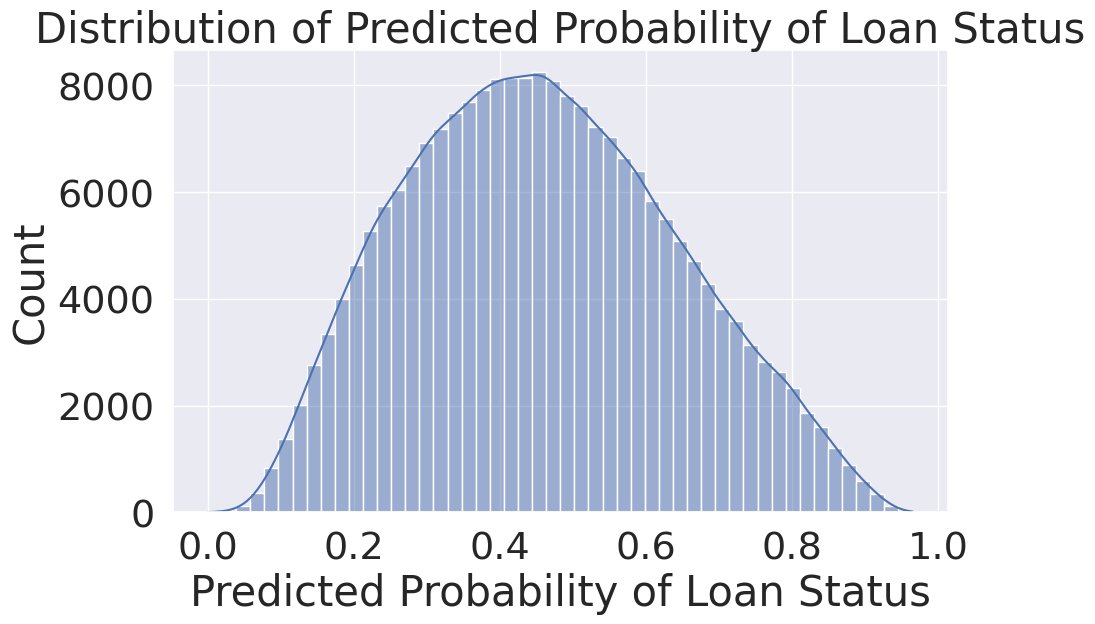

              precision    recall  f1-score   support

           0       0.88      0.66      0.75    172469
           1       0.31      0.64      0.42     41614

    accuracy                           0.65    214083
   macro avg       0.60      0.65      0.59    214083
weighted avg       0.77      0.65      0.69    214083



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

# 독립 변수와 종속 변수 분리
X = df.drop('target', axis=1)  # 독립 변수
y = df['target']  # 종속 변수

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 오버샘플링 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 다중 회귀 모델 훈련
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 특이도(Specificity), 민감도(재현율), 정확도, 정밀도 계산
conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()
specificity = TN / (TN + FP)
recall = sensitivity = TP / (TP + FN)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("특이도(Specificity):", specificity)
print("민감도(Sensitivity) 또는 재현율(Recall):", recall)
print("정확도(Accuracy):", accuracy)
print("정밀도(Precision):", precision)

# 예측 결과의 분포 시각화
y_pred_proba = model.predict_proba(X_test)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.xlabel('Predicted Probability of Loan Status')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probability of Loan Status')
plt.show()

from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test)))

## Shap 추가
출처 : https://todayisbetterthanyesterday.tistory.com/57

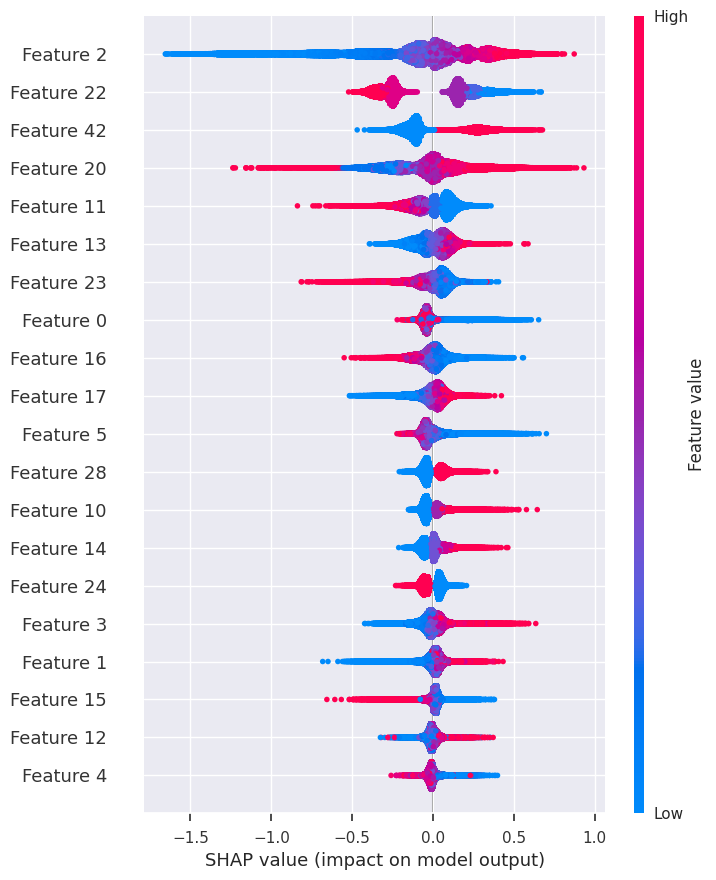

In [ ]:
explainer = shap.TreeExplainer(xgboost) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산
shap.initjs() # javascript 초기화 (graph 초기화)
shap.summary_plot(shap_values, X_test)

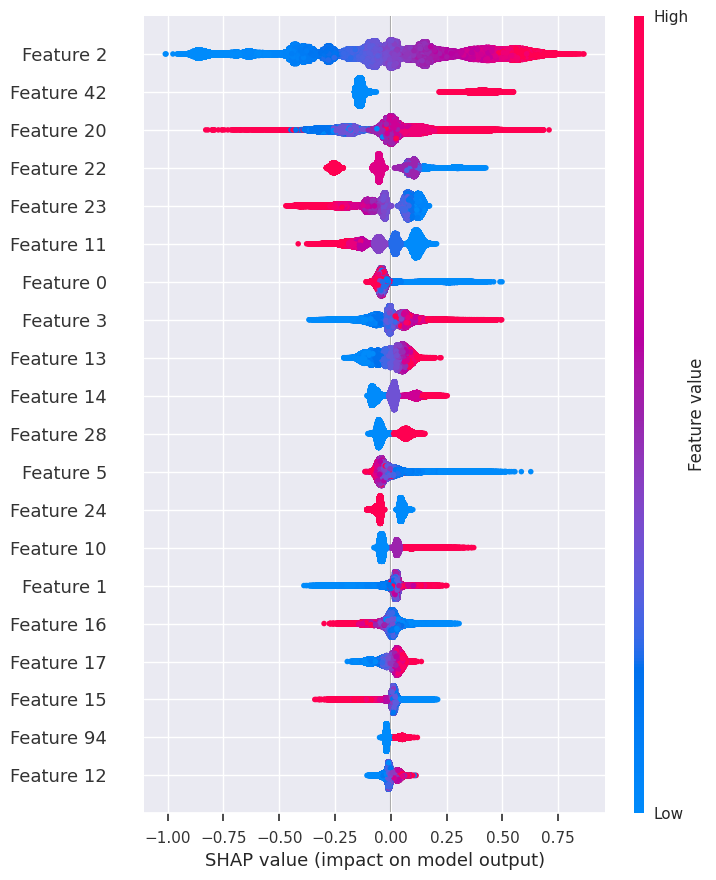

In [ ]:
explainer = shap.TreeExplainer(lgb) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산
shap.initjs() # javascript 초기화 (graph 초기화)
shap.summary_plot(shap_values, X_test)

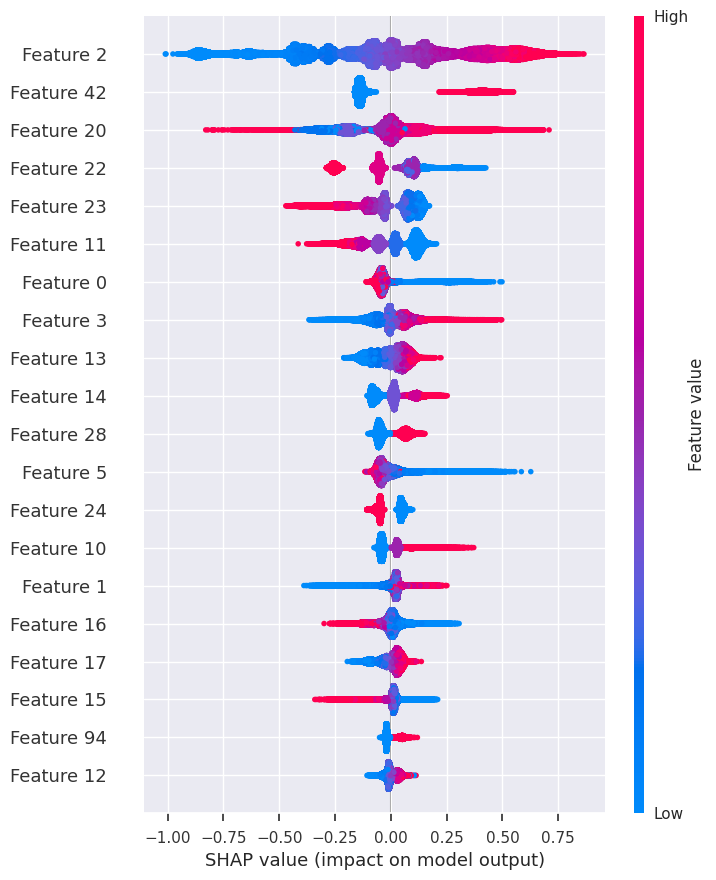

In [ ]:
explainer = shap.TreeExplainer(cat) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산
shap.initjs() # javascript 초기화 (graph 초기화)
shap.summary_plot(shap_values, X_test)

shap의 결과도 보면 전부 int rate를 가증 중요한 변수로 뽑는다